In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import njit, jit, prange, set_num_threads, get_num_threads
import scipy as sp
import time
import sys
import os
from EYFPsimfcts import *
from matplotlib.cm import ScalarMappable
from joblib import Parallel, delayed


# Add both the Code directory and its parent to Python path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

for path in [current_dir, parent_dir]:
    if path not in sys.path:
        sys.path.insert(0, path)  # Insert at beginning of path



## Simulation of Rabi oscillation in protein ensemble

In [2]:
#Initialize parameters
N_B = 100 # Pairs of theta and phi angles to sample the sphere
N_chi = 10 # Number of chi angles to sample for each (phi, theta) pair, where (theta, pi-phi) is the orientation of the B field in the molecular frame
#Note: N_mol=N_B*N_chi is the total number of molecular orientations used in the simulation
N_mol=N_B*N_chi

phi, theta, chi=Generate_molecule_set_Fibonacci_sphere(N_B, N_chi) # Generate molecular orientations using Fibonacci sphere sampling with total molecules N_mol and minimum angle 10 degrees


d = 2 # distance, unit: nm
D0 = 2.356 #GHz
E0 = 0.458 #GHz
B0 = 0.03 # T
Omega1=2*np.pi*50 #microwave strength for driving Rabi oscillation, MHz; equivalent to \gamma_B \times B_1 in the note

Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, nx, ny, nz = Transitions_calculation_numba(B0, D0, E0, Omega1, phi, theta, chi)
#Txz, Tyz: transition frequencies for each Euler angle set
#deltaxz, deltayz: detuning of the transition for each Euler angle set, with respect to the means of Txz and Tyz, respectively
#Rabi_freq_xz, Rabi_freq_yz: Rabi frequencies for each Euler angle set
#nx, ny, nz: population distribution on the three levels

In [3]:
#Simulate the Tz-Tx spectrum, and then obtain the transition frequency at the spectrum peak
gamma_linewidth = 0.03 #GHz, linewidth
f_axis = np.linspace(np.min(Txz)-gamma_linewidth*50, np.max(Txz)+gamma_linewidth*50, 1000)
I_lines = np.ones(len(Txz))/(len(Txz)) #Intensity of each line
spectrum_xz = convolve_spectrum_numba(Txz, I_lines, f_axis, gamma_linewidth)
f_at_sig_max_xz = f_axis[np.argmax(spectrum_xz)].real 

In [4]:
f_at_sig_max_xz

np.float64(3.319792754214526)

c:\Users\Hsaee\anaconda3\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Hsaee\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Hsaee\anaconda3\Lib\site-packages\numpy\ma\core.py:2892: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


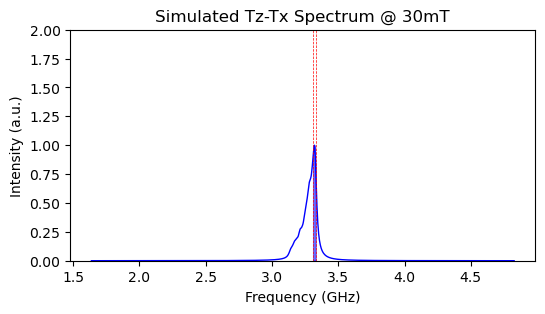

In [11]:
#Plot the spectrum simulation result
plt.figure(figsize=(6, 3))
plt.plot(f_axis, spectrum_xz/np.max(spectrum_xz), color='blue', lw=1)
plt.axvline(f_at_sig_max_xz-0.01, color='red', linestyle='--', lw=0.5)
plt.axvline(f_at_sig_max_xz+0.01, color='red', linestyle='--', lw=0.5)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Intensity (a.u.)')
plt.title('Simulated Tz-Tx Spectrum @ 30mT')
plt.ylim(0, 2)
plt.fill_between(f_axis, spectrum_xz/np.max(spectrum_xz), where=(f_axis >= f_at_sig_max_xz-0.01) & (f_axis <= f_at_sig_max_xz+0.01), color='blue', alpha=0.5)
#plt.savefig('Tz-Tx_spectrum.pdf', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'Signal')

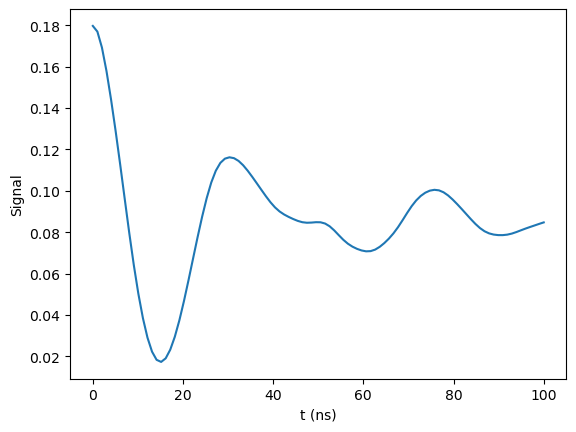

In [ ]:
time_seq=np.linspace(0, 0.1, 100)

sig=np.zeros([len(time_seq)])*(1+0j)
sz=np.array([[1, 0],[0, -1]])*(1+0j)
scale_factor=1 #Varying the mw power


for n_i in range(N_mol):
    rho0=np.array([[nx[n_i], 0],[0, nz[n_i]]])
    #rho0=np.array([[ny[n_i], 0],[0, nz[n_i]]])
    actual_detuning=deltaxz[n_i]-(f_at_sig_max_xz-Txz.mean())*np.pi*2*1000 #unit: 2pi * MHz
    H_mol=Eff_H(Rabi_freq_xz[n_i]*scale_factor, actual_detuning)
    #H_mol=Eff_H(Rabi_freq_yz[n_i]*scale_factor, deltayz[n_i])
    U_0=expm_hamiltonian(H_mol, time_seq[1])
    for t_i in range(len(time_seq)):
        #U_mol=sp.linalg.expm(-1j*H_mol*time_seq[t_i])
        #U_mol=np.linalg.matrix_power(U_0, t_i)
        U_mol=expm_hamiltonian(H_mol, time_seq[t_i])
        rho_i=U_mol@rho0@U_mol.conj().T
        #print(U_mol.trace())
        sig[t_i]+=np.trace(rho_i@sz)
plt.plot(time_seq*1000, np.real(sig)/N_mol)
plt.xlabel('t (ns)')
plt.ylabel('Signal')